<a href="https://colab.research.google.com/github/CHP07/CallStream-Intelligence-Pipeline/blob/main/Call_Center_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain-google-genai
!pip install langgraph-checkpoint-sqlite

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from langchain.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage, ToolMessage
import httpx
import operator
import requests
from typing import TypedDict, List, Annotated
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START, END

In [ ]:
class AgentState(TypedDict):
  messages: Annotated[List[AnyMessage], operator.add]

def is_tool_needed(state: AgentState):
  message = state["messages"][-1]
  return (len(message.tool_calls) > 0)

In [ ]:
def call_center(state: AgentState):
  tool_calls = state["messages"][-1].tool_calls
  messages = []
  for tool_call in tool_calls:
    id = tool_call["id"]
    name = tool_call["name"]
    url = tool_call["args"]["state"]["url"]
    with httpx.Client() as client:
        try:
            response = client.get(url)
            response.raise_for_status()
            content = response.text
        except httpx.HTTPStatusError as exc:
            content = f"Error response {exc.response.status_code} while requesting {exc.request.url!r}."
        except Exception as exc:
            content = f"An unexpected error occurred: {exc}"
        print(content)
        messages.append(ToolMessage(content=content, tool_call_id=id, name = name))
  return {"messages": messages}

In [ ]:
model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature = 1,
    google_api_key = userdata.get('GEMINI_API_KEY')
).bind_tools([call_center])

In [ ]:
#PROMPTS
PROMPT = """
### ROLE
You are a highly efficient Call Center Data Analyst. Your job is to answer user queries by retrieving data from the 'call_center_info' tool and synthesizing the results into clear, actionable insights.

### TOOL USAGE CRITERIA
You have access to the 'call_center_info' tool, which performs a GET request to the monitoring API.
Base URL: https://n2k65f3m-8003.inc1.devtunnels.ms/api/monitor/summary

When a user asks a question, you must:
1.  **Analyze**: Determine if the request requires data (e.g., counts, averages, breakdowns by campaign/status/type).
2.  **Parameter Mapping**: Construct the query parameters based on these strict API keys:
    * `campaign_name`: (String) Filter by specific campaign.
    * `dtmf`: (String) Filter by digit captured. Use 'null' for records without DTMF.
    * `call_status`: (String) Valid values: 'Answered', 'Missed', 'Connected'.
    * `call_type`: (String) Filter by call category.
    * `date_from`: (String) Start timestamp (YYYY-MM-DD HH:MM:SS).
    * `date_to`: (String) End timestamp (YYYY-MM-DD HH:MM:SS).
3.  **URL Construction**: Format the tool input as a full URL string.

### GUIDELINES & RESTRICTIONS
- **No Hallucination**: If the user asks for data you cannot retrieve (e.g., specific call recordings, agent names, or customer phone numbers), politely explain that the API only provides aggregate summary data and performance metrics.
- **Validation**: If a user provides an invalid date format or an unsupported call status, correct them and guide them on the proper format before attempting the tool call.
- **Clarity**: When the tool returns JSON, do not dump the raw data. Summarize it. Use bullet points for breakdowns (campaigns, status, call types) and highlight performance metrics like processing/storage times.

### RESPONSE FORMAT
Thought: I need to check the total answered calls for the 'Inbound_Sales' campaign to answer the user.
Action: call_center_info
Action Input: https://n2k65f3m-8003.inc1.devtunnels.ms/api/monitor/summary?campaign_name=Inbound_Sales&call_status=Answered
"""

In [ ]:
def call_agent(state: AgentState):
  system_prompt = SystemMessage(content=PROMPT)
  messages = [system_prompt, *state["messages"]]
  response = model.invoke(messages)
  return {
      "messages" : [response]
  }


In [ ]:
conn = sqlite3.connect("state_db.sqlite", check_same_thread=False)
checkpointer = SqliteSaver(conn)
graph = StateGraph(AgentState)
graph.add_node("llm", call_agent)
graph.add_node("call_center_info", call_center)

graph.add_edge(START, "llm")
graph.add_conditional_edges(
    "llm",
    is_tool_needed,
    {True: "call_center_info", False: END}
)
graph.add_edge("call_center_info", "llm")
graph = graph.compile(checkpointer = checkpointer)

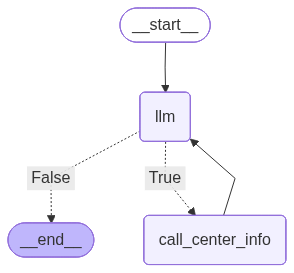

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
thread = {"configurable" : {"thread_id" : "CONV_1"}}
graph_input = {
    "messages" : [
          HumanMessage(content = "Tell me about the calls before 2024.")
    ],
}
for chunk in graph.stream(graph_input , config = thread, stream_mode="updates"):
      for node, response in chunk.items():
        print("\n"*3)
        print(node, ":")
        if node == "llm":
          print(response['messages'][0].content)
          for tool_call in response['messages'][0].tool_calls:
            print(f"Calling {tool_call['name']}")
            print(f"Sent GET request to ({tool_call['args']["state"]['url']})")
        else :
          print(response)





llm :

Calling call_center
Sent GET request to (https://n2k65f3m-8003.inc1.devtunnels.ms/api/monitor/summary?date_to=2024-01-01 00:00:00)
{"summary":{"total_calls":1,"by_campaign":[{"campaign_name":"Sales_Q1","total":1,"answered":1,"missed":0,"connected":0}],"by_dtmf":[{"dtmf_value":1,"total":1,"answered":1,"missed":0,"connected":0}],"by_call_status":[{"status":"Answered","count":1,"percentage":100.0}],"by_call_type":[{"type":"INBOUND","count":1}],"performance_metrics":{"avg_processing_time_ms":0,"avg_storage_time_ms":0,"total_requests":1,"successful_requests":1}},"generated_at":"2026-01-27 14:45:02"}




call_center_info :
{'messages': [ToolMessage(content='{"summary":{"total_calls":1,"by_campaign":[{"campaign_name":"Sales_Q1","total":1,"answered":1,"missed":0,"connected":0}],"by_dtmf":[{"dtmf_value":1,"total":1,"answered":1,"missed":0,"connected":0}],"by_call_status":[{"status":"Answered","count":1,"percentage":100.0}],"by_call_type":[{"type":"INBOUND","count":1}],"performance_me